# Corso di Quantum Computing - Giorno 3

In questo laboratorio vedremo una possibile implementazione dell'algoritmo di Simon, come costruire il circuito della Quantum Fourier Transform e, infine, come effettuare una ricerca tramite Grover e alcune sue possibili applicazioni.

Corso per Epigenesys s.r.l. <br>
Docenti: Sara Galatro e Lorenzo Gasparini <br>
Supervisore: Prof. Marco Pedicini

## Per iniziare

In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex, plot_bloch_multivector
from qiskit import transpile, Aer, execute

import numpy as np
import math
import matplotlib.pyplot as plt

## Algoritmo di Simon

Prima di procedere con l'implementazione, ricordiamo qual è il problema di Simon: supponiamo di avere una funzione $f:\Sigma^n\rightarrow\Sigma^n$ e sia *promessa* l'esistenza di una stringa $s\in\Sigma^n$ tale che
$$
    f(x)=f(y) \Leftrightarrow (x=y) \wedge (x\oplus s = y)
$$
per ogni $x,y\in\Sigma^n$. Vogliamo costruire un algoritmo che ci restituisca questa stringa sconosciuta $s$, che chiameremo **periodo**.

Dobbiamo innanzitutto definire un circuito che implementi una funzione che verifichi tale promessa: l'idea è di definire una funzione semplice che la verifichi, come ad esempio $g(x) = \min\{x,x\oplus s\}$, e poi definire $f$ come la composizione di $g$ e di una permutazione randomica degli elementi. In questo modo, $f$ soddisferà la proprietà richiesta e la sua aleatorietà renderà valida l'analisi che faremo.

A livello implementativo, alcune note:
* per trasformare una matrice (aka un operatore) unitaria generica, useremo il metodo `.unitary` con input la matrice e i qubit su cui deve agire, così da aggiungere l'operazione al circuito come gate;
* in Python, `**` è l'elevamento a potenza mentre `^` è la somma bit-wise, che matematicamente è indicata con $\oplus$.

In [25]:
def simon_function(s: str):

    """
    Create a QuantumCircuit implementing a query gate for Simon 
    problem obeying the promise for the hidden string `s`
    """

    # Our quantum circuit has 2n qubits for n = len(s)
    n = len(s)
    qc = QuantumCircuit(2*n)

    # Define a random permutation of all n bit strings. 
    pi = np.random.permutation(2**n)

    # Define a query gate explicitly
    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x^int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1

    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2*n))
    
    return qc

Definiamo ora una funzione che esegue il circuito nel problema di Simon $k$ volte e riporta i risultati:

In [24]:
def simon_measurements(problem: QuantumCircuit, k: int):

    """
    Quantum part of Simon's algorithm. Given a `QuantumCircuit` that
    implements f, get k measurements to be post-processed later.
    """

    n = problem.num_qubits//2 # // is the integer division + floor

    qc = QuantumCircuit(2*n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    result = AerSimulator().run(qc, shots=k, memory=True).result()
    
    return result.get_memory()

Nelle prossime celle, prima di procedere al post-processing, verifichiamo il funzionamento delle funzioni che abbiamo appena definito.

Potete provare anche con altri input, ma tenete a mente che il costo della simulazione è *esponenziale* rispetto al numero di qubit necessari (dunque non inserite stringhe $s$ troppo lunghe!)

In [26]:
simon_measurements(
    simon_function("11011"),
    k = 12
)

['00011',
 '00111',
 '00111',
 '01010',
 '10101',
 '11111',
 '01001',
 '10101',
 '01101',
 '01101',
 '01001',
 '00100']

Per risolvere il sistema finale, possiamo sfruttare il pacchetto `galois`, un'estensione di `Numpy` che ci permette di operare comodamente sui campi finiti. Vediamone il funzionamento su $GF(7)$:

Installiamo l'estensione:

!pip install galois

In [27]:
import galois

GF7 = galois.GF(7)
GF7

<class 'galois.GF(7)'>

Questa estensione ha numerose funzioni e metodi molto utili, come ad esempio per ottenere gli elementi del campo:

In [28]:
GF7.elements

GF([0, 1, 2, 3, 4, 5, 6], order=7)

o effettuare operazioni modulari tra classi:

In [29]:
GF7(3) + GF7(5)

GF(1, order=7)

o stampare le tabelle aritmetiche:

In [32]:
print(GF7.arithmetic_table("+"))

x + y | 0  1  2  3  4  5  6 
------|---------------------
    0 | 0  1  2  3  4  5  6 
    1 | 1  2  3  4  5  6  0 
    2 | 2  3  4  5  6  0  1 
    3 | 3  4  5  6  0  1  2 
    4 | 4  5  6  0  1  2  3 
    5 | 5  6  0  1  2  3  4 
    6 | 6  0  1  2  3  4  5 


Ma la vera forza di `galois` sono le operazioni vettoriali su campi finiti: focalizzandoci su quello che ci serve, possiamo risolvere un sistema passando a galois la matrice associata

In [50]:
matrix = np.zeros((7,7)).astype(int)

for i in range(7):
    for j in range(7):
        matrix[i,j] = np.random.randint(7)

print(matrix)

galois.GF(7)(matrix).null_space()

[[0 6 3 0 4 6 2]
 [6 0 1 4 3 1 1]
 [2 3 2 1 3 0 3]
 [1 0 3 2 0 0 2]
 [1 6 1 4 3 5 3]
 [4 6 2 6 5 4 6]
 [6 0 5 6 5 5 3]]


GF([[1, 0, 3, 4, 5, 4, 5]], order=7)

Ovviamente, dato che la matrice è generata randomicamente, non è detto che il sistema abbia una soluzione: eseguite dunque la cella precedente più volte per vedere i diversi risultati!

**Ex.1 - Costruire il circuito relativo all'algoritmo di Simon**

In [64]:
def simon_algorithm(problem: QuantumCircuit):

    """
    Given a `QuantumCircuit` that implements a query gate for Simon problem, return the hidden string `s`.
    """

    # Quantum part: run the circuit defined previously k times and gather the measurement results.
    # Replace +10 by +r for any nonnegative integer r depending on desired confidence.

    measurements = simon_measurements(problem, k=problem.num_qubits//2 + 10)
    print("Measurement results:")
    display(measurements)

    # Classical post-processing:

    # 1. Convert measurements of form '11101' to 2D-array of integers
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpret matrix as using arithmetic mod 2, and find null space
    null_space = galois.GF(2)(matrix).null_space()
    print("Null space:", null_space)
    print()

    # 3. Convert back to a string
    print("Guess for hidden string s: ",end="")
    if len(null_space) == 0:

        # No non-trivial solution; `s` is all-zeros
        print("0" * len(measurements[0]))
    
    else:

        # non-trivial period
        print("".join(np.array(null_space[0]).astype(str)))
    

Proviamo dunque il nostro algoritmo!

In [65]:
simon_algorithm(
    simon_function("10100")
)

Measurement results:


['00010',
 '10100',
 '11110',
 '11110',
 '01001',
 '10101',
 '10111',
 '01001',
 '01010',
 '11101',
 '10110',
 '11100',
 '01011',
 '10111',
 '00000']

Null space: [[1 0 1 0 0]]

Guess for hidden string s: 10100


## Implementare la Quantum Fourier Transform

Abbiamo visto poco fa la Quantum Fourier Transform, dalla sua definizione al costo computazionale in gate, dunque ora passiamo alla sua implementazione in Qiskit. In particolare, andremo a costruire i circuiti relativi alla QFT per $3$ qubit e poi per $8$ qubit.

Ricordiamone la definizione matematica tramite matrice unitaria:
$$ 
    U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{jk} \vert k \rangle \langle j \vert
$$
e ricordiamo anche che i gate principali per l'implementazione del circuito associato saranno l'Hadamard gate $\mathbf{H}$ e la rotazione controllata $\mathbf{CP}$.

### QFT a $3$ qubit

Iniziamo dunque con un esempio, implementando la QFT a tre qubit.

Ricordiamo i vari step, nello specifico caso di $n=3$, per costruire il circuito associato a $\vert y_3y_2y_1\rangle = QFT_3 \vert x_3x_2x_1\rangle$:
1. Applicare un Hadamard gate a $\vert x_1\rangle$
$$
    \psi_1\rangle = \vert x_3\rangle \otimes \vert x_2\rangle \otimes \frac{1}{\sqrt{2}} \left[ \vert0 \rangle + \exp\left(\frac{2\pi i}{2}x_1\right) \vert1\rangle\right]
$$

2. Applicare $\mathbf{UROT}_2$ a $\vert x_1\rangle$ dipendendo da $\vert x_2\rangle$
$$
    \psi_2\rangle = \vert x_3\rangle\otimes\vert x_2\rangle\otimes\frac{1}{\sqrt{2}}\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right) \vert1\rangle\right]
$$

3. Applicare $\mathbf{UROT}_3$ a $\vert x_1\rangle$ dipendendo da $\vert x_3\rangle$
$$
    \psi_3\rangle = \vert x_3\rangle\otimes\vert x_2\rangle\otimes\frac{1}{\sqrt{2}}\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right) \vert1\rangle\right]
$$

4. Applicare un Hadamard gate a $\vert x_2 \rangle$
$$
    \psi_4\rangle = \vert x_3\rangle\otimes\frac{1}{\sqrt{2}}\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_2\right) \vert1\rangle\right]\otimes\frac{1}{\sqrt{2}}\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right) \vert1\rangle\right]
$$

5. Applicare $\mathbf{UROT}_2$ a $\vert x_2\rangle$ dipendendo da $\vert x_3\rangle$
$$
    \psi_5\rangle = \vert x_3\rangle\otimes\frac{1}{\sqrt{2}}\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2\right) \vert1\rangle\right]\otimes\frac{1}{\sqrt{2}}\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right) \vert1\rangle\right]
$$

6. Applicare un Hadamard gate a $\vert x_3\rangle$
$$
    \psi_6\rangle = \frac{1}{\sqrt{2}}\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_3\right) \vert1\rangle\right]\otimes\frac{1}{\sqrt{2}}\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2\right) \vert1\rangle\right]\otimes\frac{1}{\sqrt{2}}\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1 \right) \vert1\rangle\right]
$$

7. Invertiamo l'ordine dei nostri qubit $y_1,y_3$

Ricordiamo anche che $\mathbf{CROT_k}$ è definita come
$$
\begin{bmatrix}
    \mathbb{I} & 0 \\
    0 & \mathbf{UROT}_k
\end{bmatrix}
$$
dove
$$
\mathbf{UROT}_k = 
\begin{bmatrix}
    1 & 0 \\
    0 & \exp\left( \frac{2\pi i}{2^k} \right)
\end{bmatrix}
$$
In Qiskit, possiamo effettuare le rotazioni controllate tramite $\mathbf{CP}(\theta)$, che ricordiamo essere definita come
$$
\mathbf{CP}(\theta) = 
\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & e^{i\theta}
\end{bmatrix}
$$
Dunque, per implementare $\mathbf{CROT}_k$ tramite un gate $\mathbf{CP}(\theta)$ ci basta risolvere l'equazione
$$
    \theta = \frac{2\pi}{2^k} = \frac{\pi}{2^{k-1}}
$$

**Ex.2 - Costruire il circuito relativo a $\mathbf{QFT}_3$**

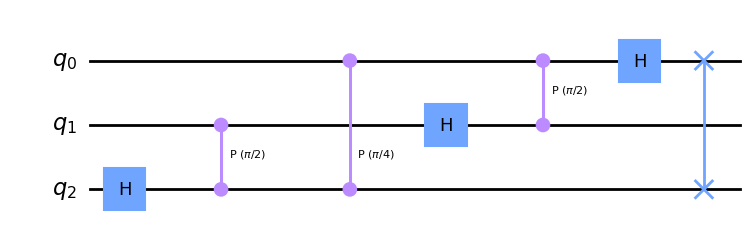

In [14]:
# define the circuit object
qft_circuit = QuantumCircuit(3)

# step 1
qft_circuit.h(2)

# step 2
qft_circuit.cp(np.pi/2, 1, 2) # CROT from qubit 1 to qubit 2

# step 3
qft_circuit.cp(np.pi/4, 0, 2) # CROT from qubit 0 to qubit 2

# step 4
qft_circuit.h(1)

# step 5
qft_circuit.cp(np.pi/2, 0, 1) # CROT from qubit 0 to qubit 1

# step 6
qft_circuit.h(0)

# step 7
qft_circuit.swap(0,2)

# draw the final circuit
qft_circuit.draw('mpl')

### Generalizzazione della QFT

La vera potenza di Qiskit è la facilità nel costruire circuiti molto grandi come stiamo per vedere.

Iniziamo definendo una funzione che ruoti correttamente i nostri qubit:

In [15]:
def qft_rotations(circuit, n):

    if n == 0: # Exit function if circuit is empty
        return circuit
    
    n -= 1 # Indexes start from 0

    circuit.h(n) # Apply the H-gate to the most significant qubit

    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

Vediamo com'è questa prima funzione:

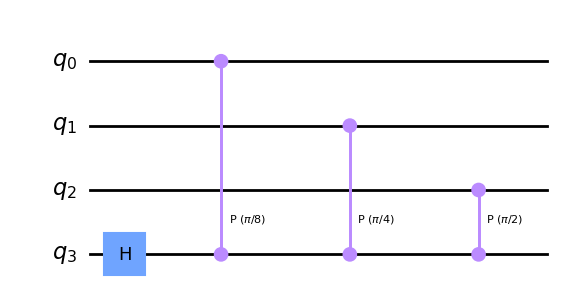

In [16]:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw('mpl')

Perfetto, questa è la prima parte della nostra QFT!

Ci resta da ruotare il secondo qubit più significativo, e poi il terzo e così via. Ma perché riscrivere un codice più volte, modificando pochi dettagli per volta, quando si può andare a definire una funzione ricorsiva che lo faccia per noi?

In [17]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""

    if n == 0:
        return circuit
    
    n -= 1

    circuit.h(n)

    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

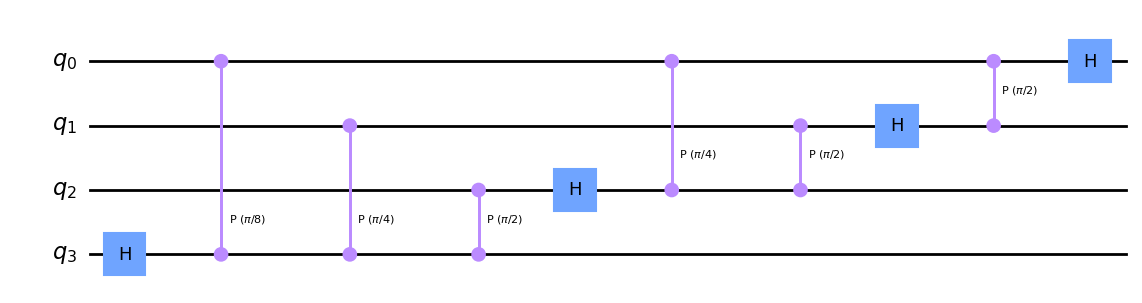

In [18]:
# Let's see how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw('mpl')

Per concludere, aggiungiamo gli swap alla fine del circuito, definendo per comodità una funzione che generi il circuito QFT completo.

In [19]:
def swap_registers(circuit, n):

    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""

    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    
    return circuit

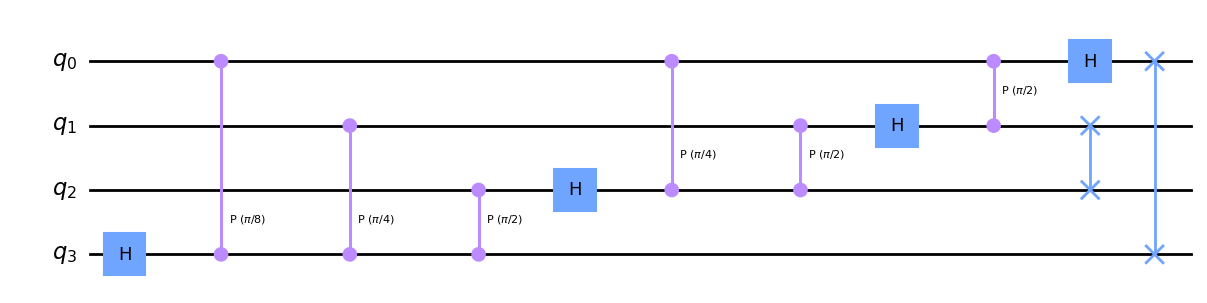

In [20]:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw('mpl')

Vogliamo ora provare che tale circuito funziona correttamente. A tal fine, ci serve di codificare un numero (scritto in binario) nel nostro circuito: ad esempio, $5 = 101$ diventa

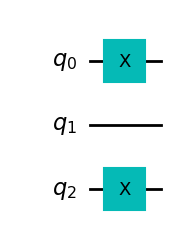

In [21]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(2)

qc.draw('mpl')

Controlliamo lo stato di tali qubit usando l'aer simulator:

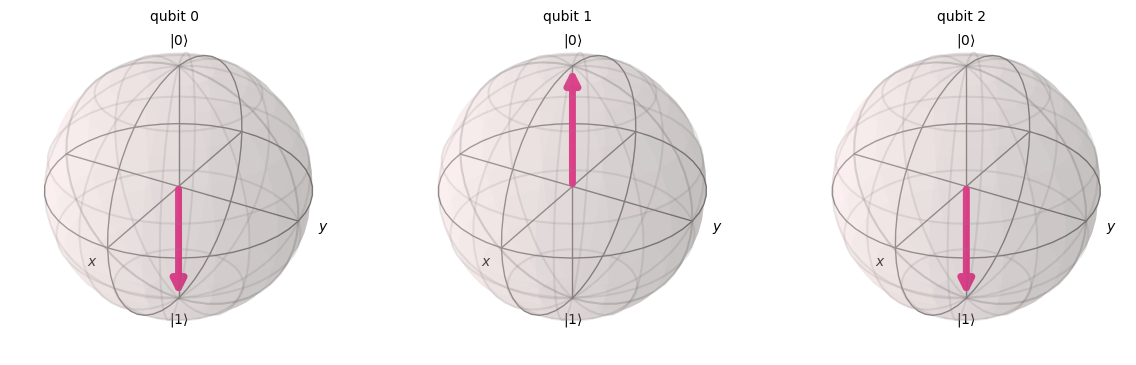

In [22]:
sim = Aer.get_backend("aer_simulator")

qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()

plot_bloch_multivector(statevector)

Usiamo ora la nostra QFT per costruire il circuito e controlliamo lo stato finale dei nostri qubit:

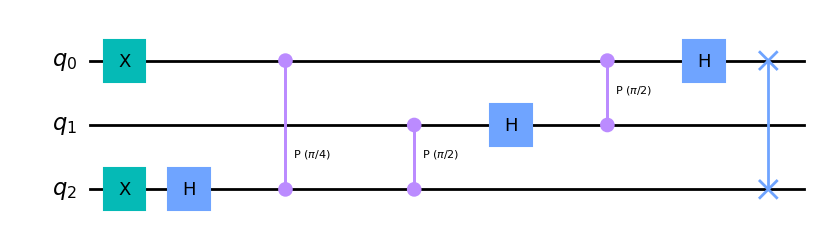

In [23]:
qft(qc,3)
qc.draw('mpl')

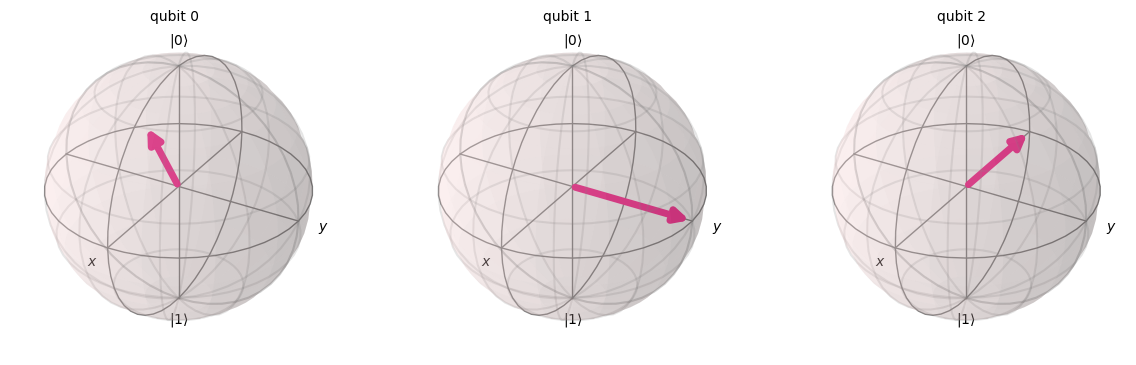

In [24]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

Possiamo dunque vedere che la nostra funzione QFT ha funzionato correttamente!

Infatti, rispetto allo stato $\vert \tilde{0}\rangle = \vert +++ \rangle$, il qubit $0$ è stato girato di $5/8$ di giro completo, il qubit $1$ di $10/8$ giri completi (i.e. di $1/4$ di giro completo) e il qubit due di $20/8$ giri completi (i.e. di $1/2$ di giro completo).

Ovviamente, data l'elevata importanza di tale operatore e il suo frequente utilizzo, Qiskit ha già una funzione al suo interno che implementa la QFT per ogni dimensione: ci basterà quindi invocare tale funzione tramite il comando

<center>

```
    QFT(num_qubits = n, approximation_degree = 0, do_swaps = True, inverse = False, insert_barriers = False, name = None)
```

</center>

per ottenere il circuito che implementi la QFT da poter inserire nel nostro algoritmo.

Link di riferimento per tutte le informazioni necessarie all'import e sui parametri: [QFT Qiskit](https://qiskit.org/documentation/stubs/qiskit.circuit.library.QFT.html)

## Algoritmo di Grover

### Caso $N=4$

Procediamo dunque con implementare l'algoritmo di ricerca di Grover partendo dal caso in cui $N=4$, ossia con $2$ qubit, in cui basta una sola iterazione per ruotare lo stato iniziale su quello *vincente*. Infatti:
1. dalla teoria, sappiamo che
$$
    \theta = \arcsin \frac{1}{2} = \frac{\pi}{6}
$$
2. dop $t$ step avremo
$$
    (\mathbf{U_s}\mathbf{U}_w)^t|s\rangle = \sin(\theta_t)|w\rangle + \cos(\theta_t) |s'\rangle \qquad \text{dove } \theta_t = (2t+1)\theta
$$
3. dato che vogliamo ottenere $|w\rangle$, vogliamo che $\theta_t = \pi/2$ e con l'ipotesi iniziale di $\theta=\pi/6$ otteniamo che $t=1$.

Supponiamo che lo stato che vogliamo trovare sia $|w\rangle=|11\rangle$ e iniziamo creando l'oracolo per tale stato, identificato dall'operatore
$$
    \mathbf{U_w}|s\rangle = \mathbf{U_w} \cdot \frac{1}{2} \left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right) = \frac{1}{2} \left( |00\rangle + |01\rangle + |10\rangle - |11\rangle \right)
$$
ossia vogliamo applicare un **controlled-Z** ai nostri due qubit:

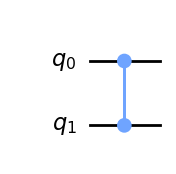

In [25]:
# oracle
oracle = QuantumCircuit(2)

oracle.cz(0,1)

oracle.draw('mpl')

Il che conclude la prima parte della nostra iterazione. Dobbiamo ora costruire la nostra riflessione rispetto a $|s\rangle$ e vogliamo che l'operatore associato $\mathbf{U}_s$ aggiunga una fase negativa ad ogni stato ortogonale rispetto a $|s\rangle$.

Un modo possibile per ottenere tale risultato è il seguente:
1. riportiamo $|s\rangle$ a $|0^2\rangle$ applicando un gate Hadamard a tutti i qubit
$$
    \mathbf{H}^{\otimes n} |s\rangle = |0^2\rangle
$$
2. applichiamo un circuito che aggiunge fase negativa agli stati ortogonali a $|0^2\rangle$;
$$
    \mathbf{U}_0\cdot \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right) = \frac{1}{2} \left( |00\rangle - |01\rangle - |10\rangle - |11\rangle \right)
$$
3. torniamo a $|s\rangle$
$$
    \mathbf{H}^{\otimes n} |0^2\rangle = |s\rangle
$$

In particolare, possiamo implementare il punto $2$ nel seguente modo:

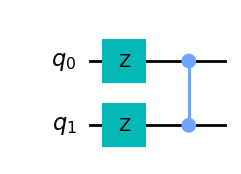

In [26]:
# reflection over |0>
ph_circuit = QuantumCircuit(2)

ph_circuit.z(range(2))
ph_circuit.cz(0,1)

ph_circuit.draw('mpl')

Tutta questa seconda parte di iterazione è detta **diffusione** e nella sua forma completa è definita come

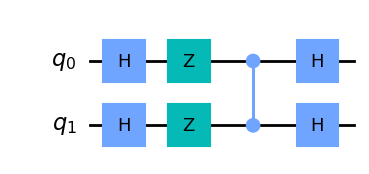

In [27]:
diffusion = QuantumCircuit(2)

diffusion.h(range(2))
diffusion.z(range(2))
diffusion.cz(0,1)
diffusion.h(range(2))

diffusion.draw('mpl')

Componendo i vari pezzi, otteniamo il nostro circuito completo:

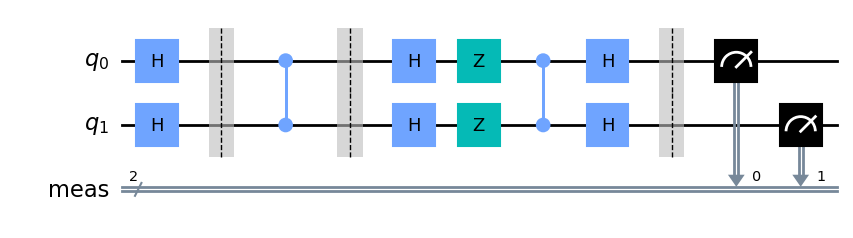

In [28]:
# define the circuit
grover = QuantumCircuit(2)

# initialize the qubits
grover.h([0,1])

# barrier
grover.barrier()

# oracle
grover.cz(0,1)

# barrier
grover.barrier()

# diffusion
grover.h(range(2))
grover.z(range(2))
grover.cz(0,1)
grover.h(range(2))

# measure
grover.measure_all()

grover.draw('mpl')


Facciamo qualche prova con i simulatori:

In [29]:
sv_sim = Aer.get_backend('statevector_simulator')

result = sv_sim.run(grover).result()
statevec = result.get_statevector()

array_to_latex(statevec, prefix="|\\psi\\rangle =")

<IPython.core.display.Latex object>

Come ci aspettavamo, ogni stato diverso da $|11\rangle$ ha ampiezza nulla e dunque misureremo con assoluta certezza lo stato cercato:

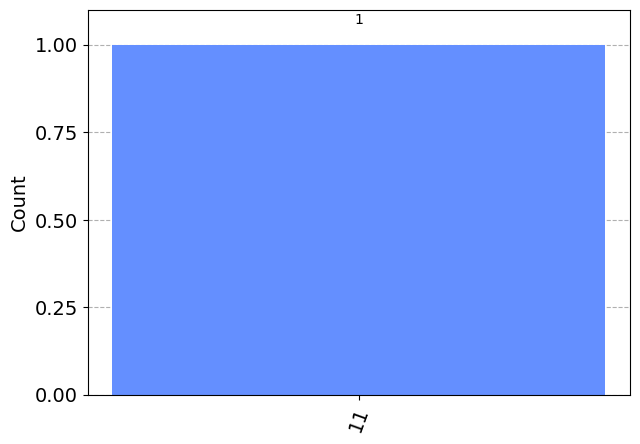

In [30]:
counts = result.get_counts()
plot_histogram(counts)

### Caso $N = 8$

Supponiamo ora di avere $3$ qubit e due stati marchiati, per l'esattezza che $|101\rangle$ e $|110\rangle$ siano i due stati soluzione che stiamo cercando.

L'algoritmo funziona sempre allo stesso modo:
1. inizializziamo i qubit nella sovrapposizione equiprobabile;
2. marchiamo gli stati soluzione con il nostro oracolo;
3. applichiamo l'operatore di diffusione;
4. misuriamo i nostri qubit.

Dato che ci sono due soluzioni possibili su uno spazio totale di $8$ possibili esiti, ci basta nuovamente una sola iterazione dei punti $(1)-(3)$.

**Ex.3 - Implementate l'algoritmo, ricavando esplicitamente gli operatori, per N=8**

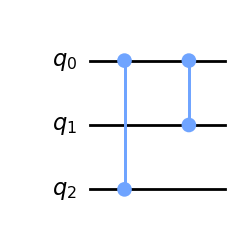

In [31]:
# oracle_3
oracle_3 = QuantumCircuit(3)

########################

oracle_3.cz(2,0)
oracle_3.cz(1,0)

########################

oracle_3.draw('mpl')

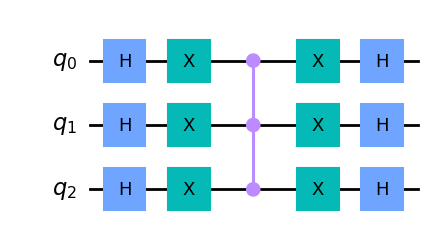

In [32]:
# diffusion_3
diffusion_3 = QuantumCircuit(3)

########################

diffusion_3.h(range(3))
diffusion_3.x(range(3))
diffusion_3.ccz(2,1,0)
diffusion_3.x(range(3))
diffusion_3.h(range(3))

########################

diffusion_3.draw('mpl')

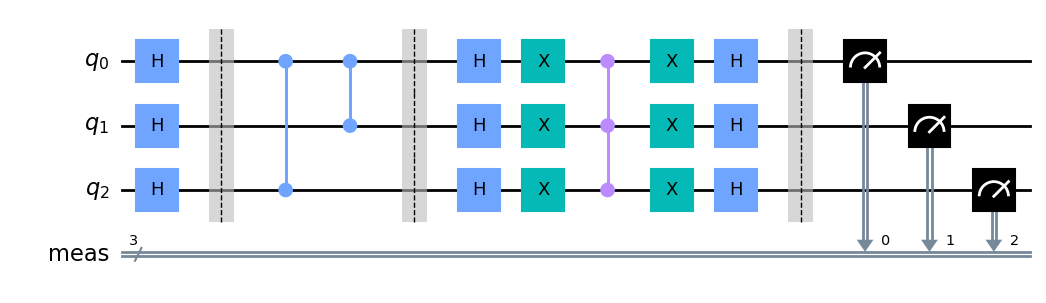

In [33]:
# grover circuit
grover_3 = QuantumCircuit(3)

# initialize
grover_3.h(range(3))

# barrier
grover_3.barrier()

# oracle
grover_3.compose(oracle_3, inplace=True)

# barrier
grover_3.barrier()

# diffuse
grover_3.compose(diffusion_3, inplace=True)

# measure
grover_3.measure_all()

grover_3.draw('mpl')

Se proviamo ad eseguirlo su un simulatore otteniamo come esiti della misurazioni solo gli stati soluzione:

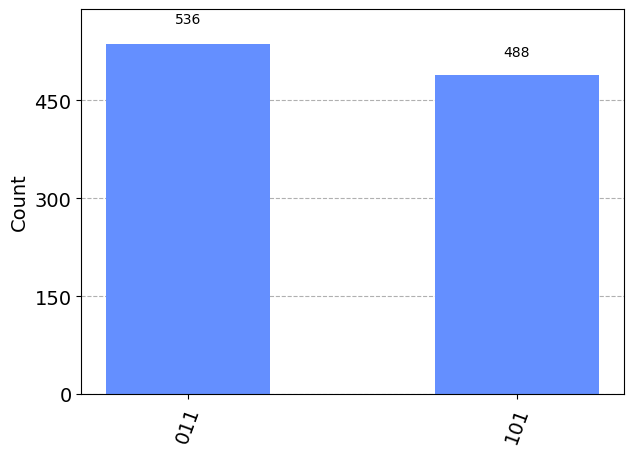

In [34]:
qasm_sim = Aer.get_backend('qasm_simulator')

transpiled_grover_circuit = transpile(grover_3, qasm_sim) # necessary cause of ccz
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()

plot_histogram(counts)

### Applicazioni: problemi di soddisfacibilità

Fino ad ora, abbiamo sempre costruito il nostro oracolo presupponendo di conoscere le soluzioni, ma nella realtà raramente ci troveremo in questa situazione. 

Prendiamo ad esempio un sudoku $2\times 2$ a variabili binarie e supponiamo di volerlo risolvere secondo le regole classiche, ossia
* nessuna colonna può avere due valori ripetuti
* nessuna riga può avere due valori ripetuti

Possiamo immaginare il nostro sudoku e le nostre variabili come una tabella

<center>

| | colonna 1 | colonna 2 |
| :------:| :------: | :------: |
| **riga 1** | $v_0$ | $v_2$ |
| **riga 2** | $v_1$ | $v_3$ |

</center>

Ovviamente in questo caso potremmo risolvere questo sudoku a mente senza troppi problemi e utilizzare un quantum computer è decisamente poco pratico, ma questo esempio ci serve per vedere come trasformare i **problemi di decisione** in oracoli per Grover, allargando così il campo di applicazioni di tale algoritmo.

Quello che dobbiamo fare è innanzitutto definire una funzione classica, eseguibile tramite gate quantistici, che verifichi se lo stato del nostro sistema sia una soluzione oppure no. In particolare, nel nostro caso del sudoku $2\times 2$, abbiamo quattro condizioni da verificare:

<center>

$v_0 \neq v_1 \quad$ `# check row 1`

$v_2 \neq v_3 \quad$ `# check row 2`

$v_0 \neq v_2 \quad$ `# check column 1`

$v_1 \neq v_3 \quad$ `# check column 2`

</center>

che riassumiamo per comodità nella seguente lista

In [35]:
clause_list = [ [0,1],
               [0,2],
               [1,3],
               [2,3] ]

Per controllare tali condizioni, dato che siamo in campo binario, ci basta applicare lo $\mathbf{XOR}$ gate ai qubit che rappresentano le variabili:

In [36]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

In questo modo, il qubit di output sarà flippato solo se i due valori di input sono diversi.

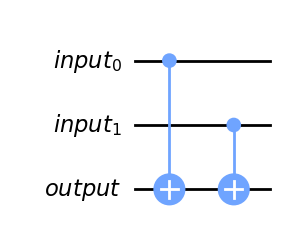

In [37]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')

qc = QuantumCircuit(in_qubits, out_qubit)

XOR(qc, in_qubits[0], in_qubits[1], out_qubit)

qc.draw('mpl')

Dato che abbiamo quattro condizioni, dovremo ripetere quest'ultimo circuito quattro volte, ogni volta applicato a una coppia di qubit diversa:

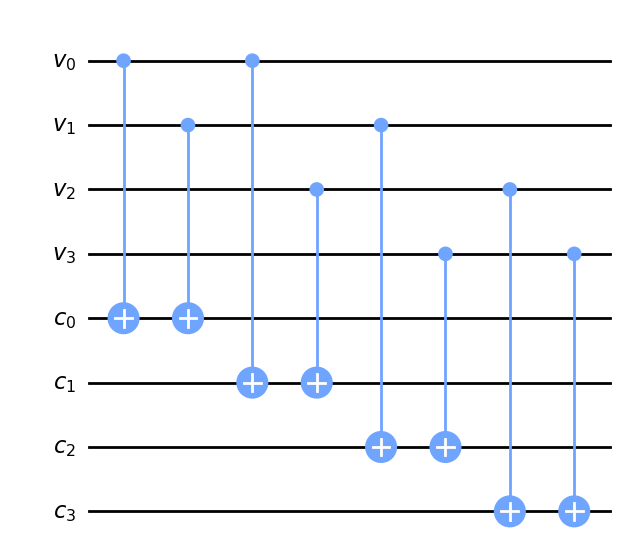

In [38]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw('mpl')

Per ottimizzare la nostra lettura dell'informazione data in output da questo circuito, vogliamo infine aggiungere un singolo bit classico `out` tale che
$$
    \begin{cases}
        out = 1 & \text{iff } c_0 = c_1 = c_2 = c_3 = 1 \Leftrightarrow v_0,v_1,v_2,v_3 \text{ è soluzione del nostro sudoku}\\
        out = 0 & \text{altrimenti}
    \end{cases}
$$

Possiamo dunque implementare questa azione di riassunto con un semplice **multi-controlled-Toffoli gate**:

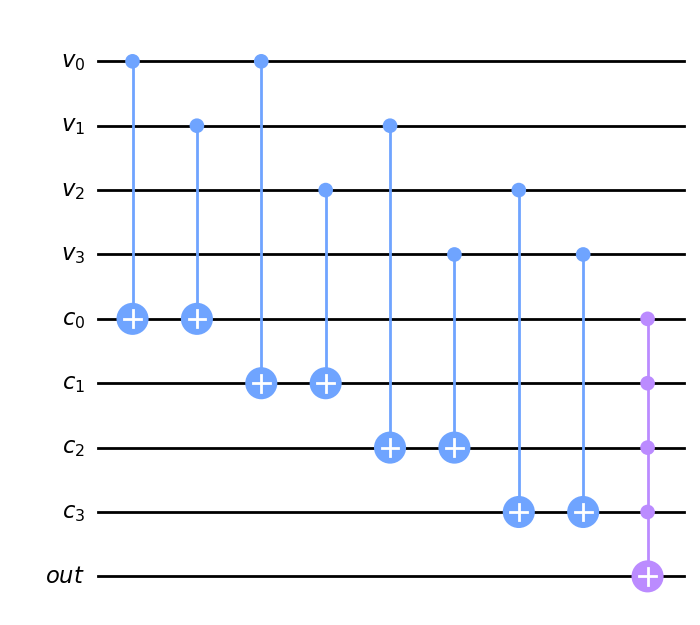

In [39]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw('mpl')

Possiamo dunque completare il nostro oracolo di Grover aggiungendo le operazioni necessarie che invertano la fase degli stati soluzione. In particolare, dati i nostri tre registri, vogliamo che il nostro oracolo attui il seguente effetto:
$$
    \mathbf{U}_w  \underbrace{|x\rangle}_{4 \: qubit} \underbrace{|0^4\rangle}_{4\: bit} \underbrace{|out\rangle}_{1 \: qubit} = |x\rangle |0^4\rangle |out\oplus f(x)\rangle
$$

In particolare, osserviamo che se inizializziamo il nostro qubit di output come $|-\rangle$, otteniamo che
$$
    \mathbf{U}_w |x\rangle |0^4\rangle |-\rangle = \mathbf{U}_w |x\rangle |0^4\rangle \otimes \frac{1}{\sqrt{2}} \left( |0\rangle - |1\rangle \right)
    = |x\rangle |0^4\rangle \otimes \frac{1}{\sqrt{2}}\left( |0\oplus f(x)\rangle - |1 \oplus f(x)\rangle \right)
    = 
    \begin{cases}
        |x\rangle |0^4\rangle |-\rangle & \text{se } f(x) = 0 \\
        -|x\rangle |0^4\rangle |-\rangle & \text{se } f(x) = 1
    \end{cases}
$$
che effettivamente è l'effetto che desideriamo!

L'ultima osservazione necessaria è che, per garantire il corretto funzionamento dell'oracolo, dobbiamo *annullare* le operazioni effettuate sul registro classico e re-inizializzarlo a $0000$: a tal fine, ci basta riapplicare le stesse operazioni che avevamo effettuato per verificare le condizioni, sfruttando il trucco del *compute/uncompute*.

In [40]:
def sudoku_oracle(qc, clause_list, clause_qubits):
    
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

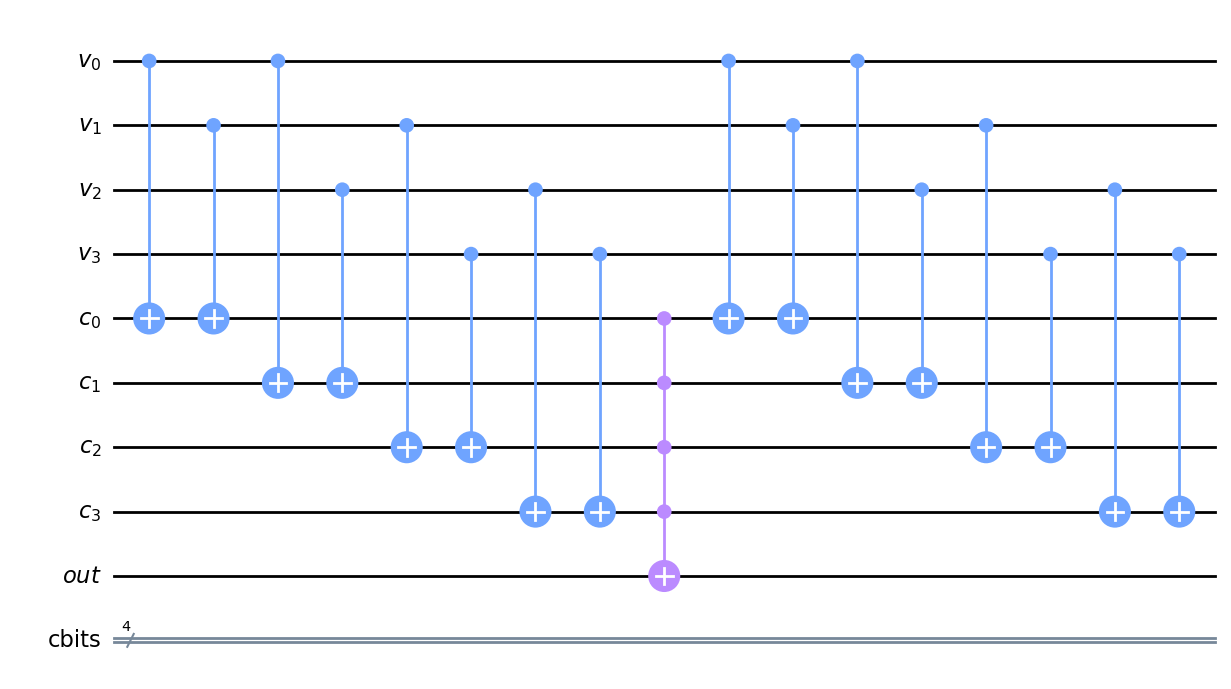

In [41]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')

qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw('mpl')

Riassumendo, l'oracolo appena definito opera nel seguente modo:
$$
    \mathbf{U}_w |x\rangle |0^4\rangle |out\rangle =
    \begin{cases}
        |x\rangle |0^4\rangle |out\rangle & \text{se } x\neq w \\
        |x\rangle |0^4\rangle \otimes \mathbf{X}|out\rangle & \text{se } x = w
    \end{cases}
$$
che supponendo di inizializzare l'ultimo qubit come $|-\rangle$ equivale a 
$$
    \mathbf{U}_w |x\rangle |0^4\rangle |-\rangle =
    \begin{cases}
        |x\rangle |0^4\rangle |-\rangle & \text{se } x\neq w \\
        -|x\rangle |0^4\rangle |-\rangle & \text{se } x = w
    \end{cases}
$$

Il circuito completo richiede anche l'operatore diffusione, visto nei casi precedenti, che però deve essere implementato ora su $4$ qubit. Non approfondiremo molto, ma l'idea è di generalizzare quanto visto nei casi $n=2,4$ applicando sempre dei gate Hadamard, bit-flip e controlled phase-flip. Riportiamo il codice che lo implementa:

In [42]:
def diffuser(nqubits) -> 'gate':

    qc = QuantumCircuit(nqubits)

    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)

    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)

    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)

    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)

    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)

    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    
    return U_s

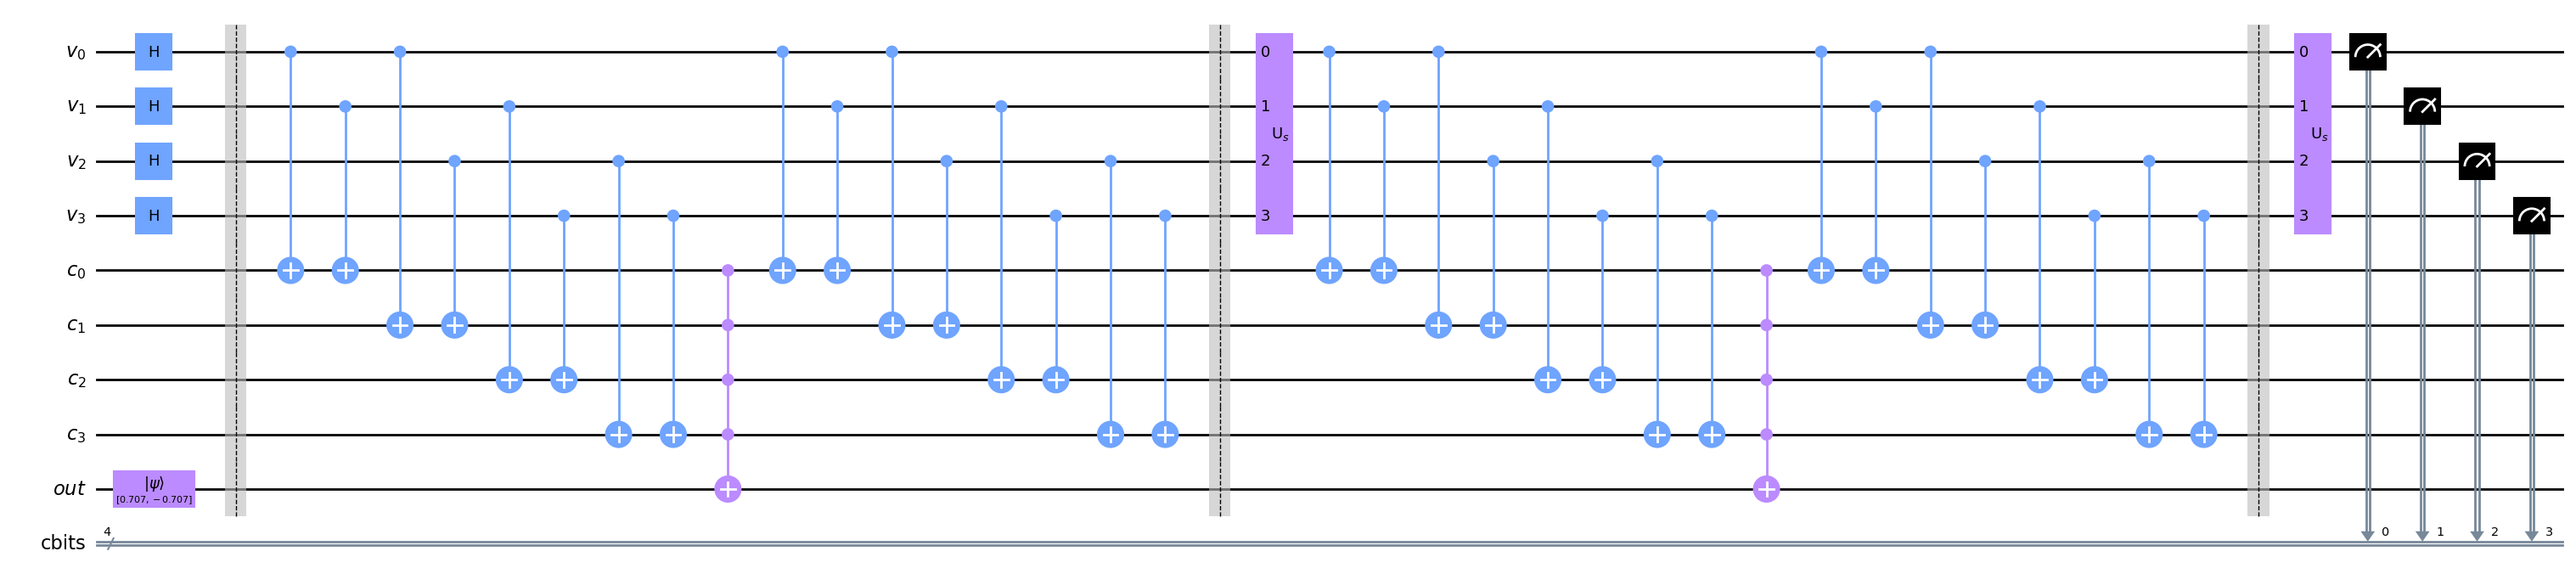

In [43]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')

qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw('mpl',fold=-1)

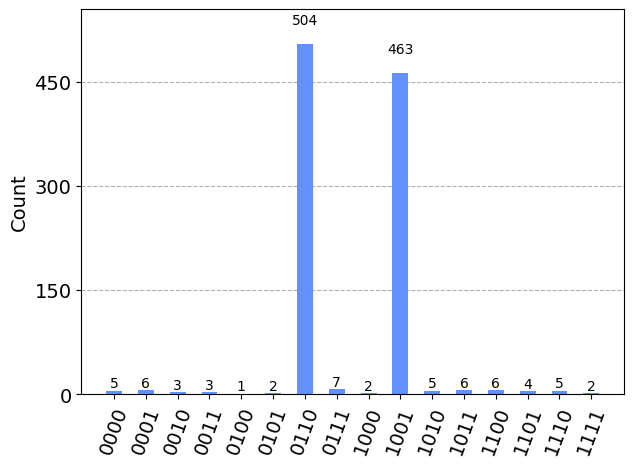

In [44]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc).result()
plot_histogram(result.get_counts())

Le stringhe che otteniamo sono $0110$ e $1001$, che effettivamente sono le uniche due configurazioni accettabili per il nostro sudoku.

Dunque l'algoritmo di Grover funziona!

### Applicazioni: ricerca di triangoli in un grafo

Un problema di notevole importanza nella teoria dei grafi è quello di trovare i triangoli all'interno di un dato grafo: dato un grafo semplice e non orientato $G = (V,E)$, che può contenere o meno triangoli, ci viene chiesto di trovare i triangoli (se esistono) e restituire i vertici che li compongono. Ad esempio nel grafo definito di seguito, abbiamo $4$ nodi e un triangolo tra i vertici $1,2,0$:

<center>

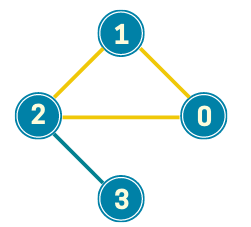

</center>

In [45]:
# Edges list
edges =[(0, 1), (0, 2), (1, 2), (2, 3)]

# Number of nodes
n_nodes = 4

Applicheremo l'algoritmo di Grover per effettuare tale ricerca, dove useremo come input il numero di vertici e la lista di lati. 

Concentriamoci sull'istanza appena presentata per comodità, ma il procedimento si può ovviamente generalizzare a grafi di dimensioni maggiori.

Per trovare i triangoli, dovremo analizzare singolarmente tutti i sottografi del nostro grafo e verificare che tipo di grafo siano. A tal fine, utilizzeremo $4$ qubit, il cui stato indicherà se il vertice corrispondente faccia parte o meno del sottografo che vogliamo analizzare. Ad esempio, lo stato $|1110\rangle$ è lo stato che  identifica il nostro triangolo, dato che identifica i nodi $0,1,2$ come parte del sottografo ed esclude $0$.

Per l'inizializzazione dello stato abbiamo due possibilità:
* possiamo utilizzare una semplice sovrapposizione equiprobabile di tutti i possibili stati (i.e applichiamo Hadamard a tutti i qubit), a cui seguiranno **tre** iterazioni di oracolo e diffusione per trovare il nostro triangolo;
* possiamo inizializzare il nostro stato come $|W_n\rangle$, dato che effettivamente ci interessano solo gli stati con $3$ qubit attivi, riducendo il numero di iterazioni necessarie a **uno**. 

Dato il vantaggio computazionale, procederemo con questa seconda inizializzazione. Ricordando che 
$$
    |W_n\rangle = \frac{1}{\sqrt{N}} \left( |1\ldots 0\rangle  + |01\ldots 0\rangle + \cdots + |0\ldots 01\rangle\right)
$$
ci basta applicare poi degli $\mathbf{X}$ gate per ottenere l'inizializzazione desiderata.

In questo caso dunque useremo $|W_4\rangle$, che procediamo a costruire nella cella successiva. Non analizzeremo la validità o il costo specifico di tale costruzione, ma vi riportiamo l'articolo di riferimento per completezza: [link all'articolo](https://arxiv.org/abs/1807.05572).

In [46]:
#We used the W state implementation from W state in reference
def control_rotation (qcir,cQbit,tQbit,theta):
    """ Create an intermediate controlled rotation using only unitary gate and controlled-NOT
    
    Args:
    qcir: QuantumCircuit instance to apply the controlled rotation to.
    cQbit: control qubit. 
    tQbit: target qubit.
    theta: rotation angle.
    
    Returns:
    A modified version of the QuantumCircuit instance with control rotation applied.
    
    """
    theta_dash = math.asin(math.cos(math.radians(theta/2)))
    qcir.u(theta_dash,0,0,tQbit)
    qcir.cx(cQbit,tQbit)
    qcir.u(-theta_dash,0,0,tQbit)
    return qcir


def wn (qcir,qbits): 
    """ Create the W-state using the control-rotation function.
    
    Args:
    qcir: QuantumCircuit instance used to construct the W-state.
    qbits: the qubits used to construct the W-state.
    
    Returns:
    A modified version of the QuantumCircuit instance with the W-state construction gates.
    
    """
    for i in range(len(qbits)):
        if i == 0:
            qcir.x(qbits[0])
            qcir.barrier()
        else:
            p = 1/(len(qbits)-(i-1))
            theta = math.degrees(math.acos(math.sqrt(p)))
            theta = 2* theta
            qcir = control_rotation(qcir,qbits[i-1],qbits[i],theta)
            qcir.cx(qbits[i],qbits[i-1])
            qcir.barrier()
    return qcir,qbits

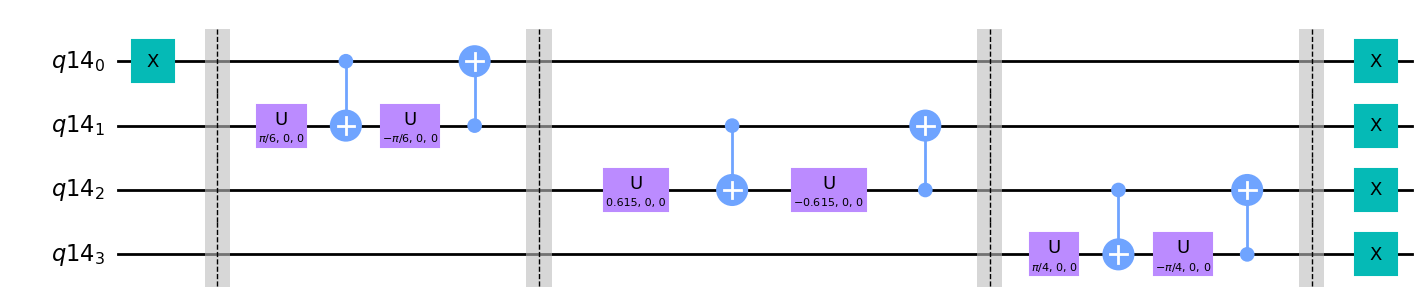

In [47]:
sub_qbits = QuantumRegister(n_nodes)
sub_cir = QuantumCircuit(sub_qbits, name="state_prep")

sub_cir, sub_qbits = wn(sub_cir, sub_qbits)
sub_cir.x(sub_qbits)

stat_prep = sub_cir.to_instruction()
inv_stat_prep = sub_cir.inverse().to_instruction()

sub_cir.draw('mpl')

Dobbiamo ora costruire l'oracolo, il cui compito sarà quello di segnare lo stato soluzione. In questo caso, l'oracolo dovrà prendere in input ogni sottografo con tre nodi e contare il numero di spigoli presenti: se tale numero è $3$, allora si tratta di un triangolo e ne salveremo i dati così da restituirli in output. 

Per ogni spigolo, useremo uno o due $\mathbf{CNOT}$ applicandoli a due qubit ancilla, che assumeranno lo stato $|11\rangle$ se si è trovato un triangolo. Nel nostro caso, bastano due qubit ancilla dato che un triangolo ha $3$ lati e la sua scrittura binaria è $11_b$.

L'ultimo step dell'oracolo è applicare un Toffoli gate, che si attiverà solo nel caso in cui si è trovato un triangolo, cambiando così lo stato di un ulteriore qubit, che chiameremo `tri_flag`, da $|0\rangle$ a $|1\rangle$.

In [48]:
def edge_counter(qc,qubits,anc,flag_qubit,k):

    bin_k = bin(k)[2:][::-1]
    l = []

    for i in range(len(bin_k)):
        if int(bin_k[i]) == 1:
            l.append(qubits[i])
            
    qc.mct(l,flag_qubit,[anc])
    
    
def oracle(n_nodes, edges, qc, nodes_qubits, edge_anc, ancilla, neg_base):

    k = 3 #k is the number of edges, in case of a triangle, it's 3

    # Edge counter
    # forward circuit
    qc.barrier()
    qc.ccx(nodes_qubits[edges[0][0] ],nodes_qubits[edges[0][1] ],edge_anc[0])

    for i in range(1,len(edges)):
        qc.mct([nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0] ], edge_anc[1], [ancilla[0] ])
        qc.ccx(nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0])

    #----------------------------------------------------------------------------------------------------------

    # Edges check Qubit
    edg_k = int((k/2)*(k-1))
    edge_counter(qc,edge_anc,ancilla[0],neg_base[0],edg_k)

    #----------------------------------------------------------------------------------------------------------

    # Reverse edge count
    for i in range(len(edges)-1,0,-1):
        qc.ccx(nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0])
        qc.mct([nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0] ], edge_anc[1], [ancilla[0] ])

    qc.ccx(nodes_qubits[edges[0][0] ],nodes_qubits[edges[0][1] ],edge_anc[0])
    qc.barrier()

Come abbiamo visto, l'operatore di diffusione dipende dal tipo di inizializzazione che abbiamo deciso di effettuare, nel nostro caso $|W_n\rangle$. Avremo dunque bisogno di invertire lo stato $|W_n\rangle$, applicare poi un multi-controlled $\mathbf{Z}$ gate e infine ritornare allo stato $|W_n\rangle$ originale:

In [49]:
def cnz(qc, num_control, node, anc):

    """Construct a multi-controlled Z gate
    Args:
        num_control : number of control qubits of cnz gate
        node : node qubits
        anc : ancillaly qubits
    """

    if num_control>2:

        qc.ccx(node[0], node[1], anc[0])

        for i in range(num_control-2):
            qc.ccx(node[i+2], anc[i], anc[i+1])

        qc.cz(anc[num_control-2], node[num_control])

        for i in range(num_control-2)[::-1]:
            qc.ccx(node[i+2], anc[i], anc[i+1])

        qc.ccx(node[0], node[1], anc[0])

    if num_control==2:

        qc.h(node[2])
        qc.ccx(node[0], node[1], node[2])
        qc.h(node[2])

    if num_control==1:
        
        qc.cz(node[0], node[1])

In [50]:
def grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep):

    qc.append(inv_stat_prep,qargs=nodes_qubits)
    qc.x(nodes_qubits)

    #====================================================
    #3 control qubits Z gate
    cnz(qc,len(nodes_qubits)-1,nodes_qubits[::-1],ancilla)
    #====================================================
    
    qc.x(nodes_qubits)
    qc.append(stat_prep,qargs=nodes_qubits)

Adesso che abbiamo tutti i pezzi, possiamo costruire l'algoritmo di Grover:

In [51]:
# Grover algo function
def grover(n_nodes,stat_prep,inv_stat_prep):

    #N = 2**n_nodes  # for optimal iterations count if the state prep is done using only H gates
    N = math.comb(n_nodes, 3) #Since we are using W-state to perform initial preparation

    nodes_qubits = QuantumRegister(n_nodes, name='nodes')
    edge_anc = QuantumRegister(2, name='edge_anc')
    ancilla = QuantumRegister(n_nodes-2, name = 'cccx_diff_anc')
    neg_base = QuantumRegister(1, name='check_qubits')
    class_bits = ClassicalRegister(n_nodes, name='class_reg')
    tri_flag = ClassicalRegister(3, name='tri_flag')

    qc = QuantumCircuit(nodes_qubits, edge_anc, ancilla, neg_base, class_bits, tri_flag)

    # Initialize quantum flag qubits in |-> state
    qc.x(neg_base[0])
    qc.h(neg_base[0])

    # Initializing i/p qubits in superposition
    qc.append(stat_prep,qargs=nodes_qubits)
    qc.barrier()

    # Calculate iteration count
    iterations = math.floor(math.pi/4*math.sqrt(N))

    # Calculate iteration count
    for i in np.arange(iterations):
        qc.barrier()
        oracle(n_nodes, edges, qc, nodes_qubits, edge_anc,  ancilla, neg_base)
        qc.barrier()
        grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep)

    qc.measure(nodes_qubits,class_bits)

    return qc

Stampiamo il circuito

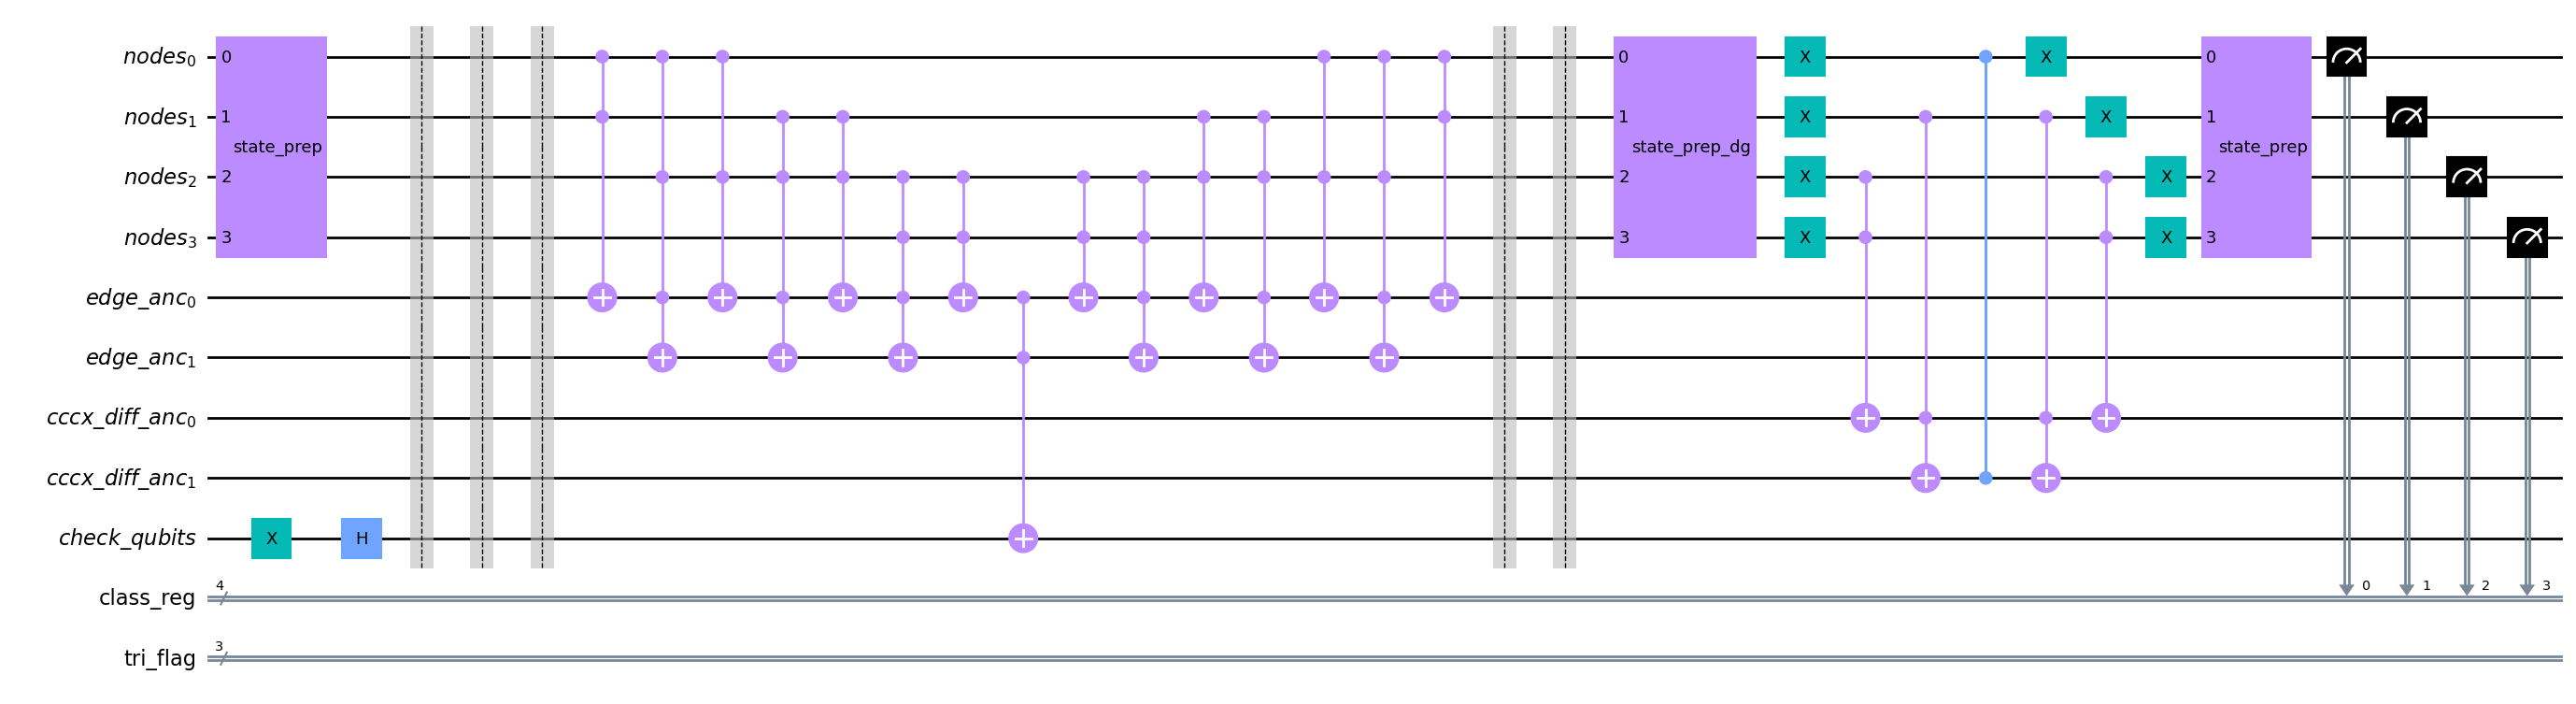

In [52]:
qc = grover(n_nodes,stat_prep,inv_stat_prep)
qc.draw('mpl', fold = -1)

e proviamo a simularne il funzionamento:

{'000 0111': 5000}


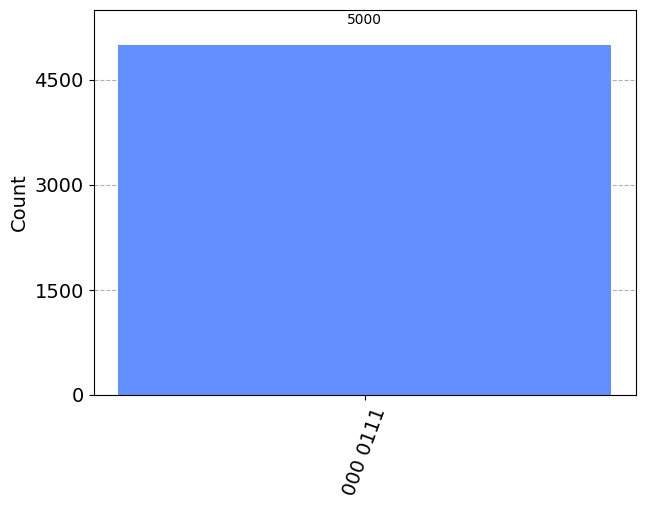

In [54]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')

#transpiled_qc = transpile(qc, qasm_simulator)

# Execute circuit and show results
ex = execute(qc, qasm_simulator, shots = 5000)
res = ex.result().get_counts(qc)

print(res)

plot_histogram(res)

Lo stato in output è ovviamente formato da tutti i qubit che formano il nostro sistema, ma quelli che identificano la nostra soluzione sono gli ultimi quattro, ossia la stringa $1110$ (ndr. ricordiamo che Qiskit ordina i qubit in ordine inverso rispetto a quello di lettura), che effettivamente è il nostro triangolo!

Quest'ultima applicazione dell'algoritmo di Grover è basata sull'articolo ["*Quantum Algorithms for the Triangle Problem*"](https://arxiv.org/abs/quant-ph/0310134) di Frederic Magniez, Miklos Santha, Mario Szegedy.